LSTM Model for Time Series Prediction:
In this project, we have developed an LSTM model to predict the time series data, with a focus on filling missing values and hyperparameter tuning using RandomSearch. Below is a structured explanation of each phase:

Data Preprocessing:
We begin by preprocessing the dataset, including handling missing values, applying stationarity tests, and scaling the data for better performance in the LSTM model.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
# Load dataset
data = pd.read_csv(r'C:/Users/jyo14/Downloads/NIFTY50_all.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.drop(columns='Series', inplace=True)

# Handle missing values with backfill
data['Deliverable Volume'] = data.groupby('Symbol')['Deliverable Volume'].fillna(method='bfill')
data['%Deliverble'] = data.groupby('Symbol')['%Deliverble'].fillna(method='bfill')

# Drop rows with missing values in selected columns
x = data.loc[:, ["Prev Close", "Open", "High", "Low", "Last", "Close", "VWAP", "Volume", "Turnover", "Deliverable Volume", "%Deliverble"]].dropna()
y = data["Trades"].notnull()

# Fill missing 'Trades' using a linear regression model
x_test = data[data["Trades"].isnull()].loc[:, ["Prev Close", "Open", "High", "Low", "Last", "Close", "VWAP", "Volume", "Turnover", "Deliverable Volume", "%Deliverble"]]
model = LinearRegression()
model.fit(x, y)
data.loc[data["Trades"].isnull(), "Trades"] = model.predict(x_test)


In [15]:
data['Symbol'].replace({"BHARTI":"BHARTIARTL" ,"HDFC":"HDFCBANK","HEROHONDA":"HEROMOTOCO","HINDALC0":"HINDALCO","HINDLEVER":"HINDUNILVR",
"INFOSYSTCH":"INFY","JSWSTL":"JSWSTEEL","KOTAKMAH":"KOTAKBANK" ,"ZEEL":"ZEETELE","TISCO":"TATASTEEL","BAJAJFINSV":"BAJFINANCE","BAJAJ-AUTO":"BAJAUTOFIN","UNIPHOS":"UPL"},inplace = True)

In [17]:
data.to_csv('nifty')

In [33]:
data.columns

Index(['Date', 'Symbol', 'Prev Close', 'Open', 'High', 'Low', 'Last', 'Close',
       'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble'],
      dtype='object')

In [5]:
import tensorflow as tf

In [ ]:
import warnings 
from warnings.filterwarnings('ignore')

Stationarity Test:
We perform the Augmented Dickey-Fuller (ADF) test to assess whether the time series is stationary, a critical assumption for time series forecasting models like LSTM.

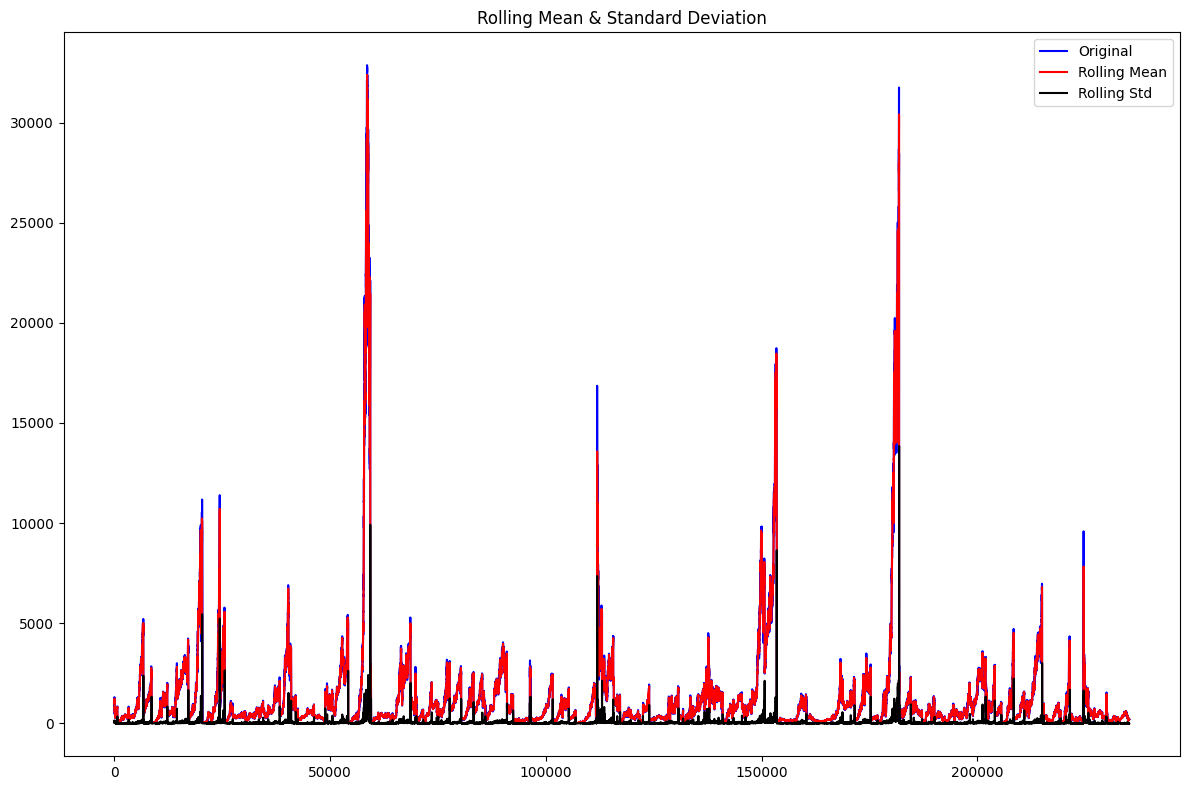

Results of Dickey-Fuller Test for Close:
Test Statistic                -9.109005e+00
p-value                        3.440000e-15
#Lags Used                     8.200000e+01
Number of Observations Used    2.351090e+05
Critical Value (1%)           -3.430378e+00
Critical Value (5%)           -2.861552e+00
Critical Value (10%)          -2.566777e+00
dtype: float64


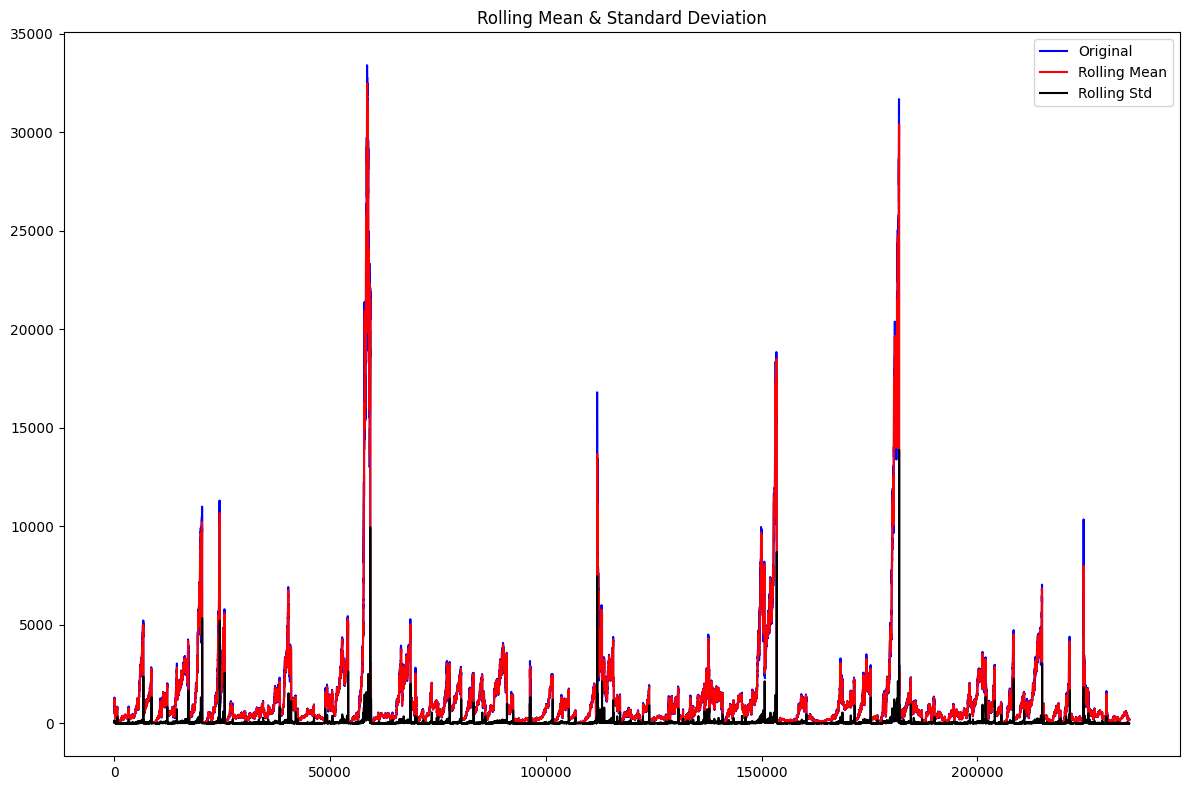

Results of Dickey-Fuller Test for Open:
Test Statistic                -9.139147e+00
p-value                        2.880848e-15
#Lags Used                     8.300000e+01
Number of Observations Used    2.351080e+05
Critical Value (1%)           -3.430378e+00
Critical Value (5%)           -2.861552e+00
Critical Value (10%)          -2.566777e+00
dtype: float64


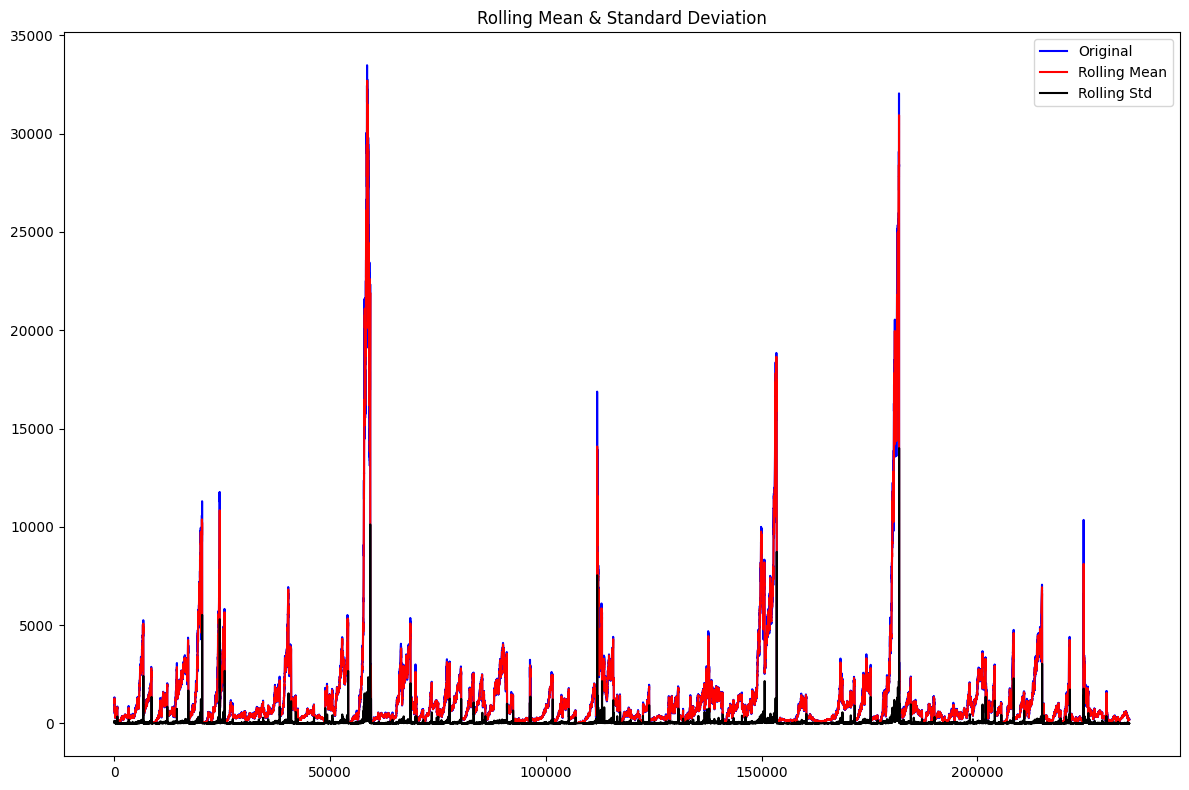

Results of Dickey-Fuller Test for High:
Test Statistic                -9.163329e+00
p-value                        2.498797e-15
#Lags Used                     8.300000e+01
Number of Observations Used    2.351080e+05
Critical Value (1%)           -3.430378e+00
Critical Value (5%)           -2.861552e+00
Critical Value (10%)          -2.566777e+00
dtype: float64


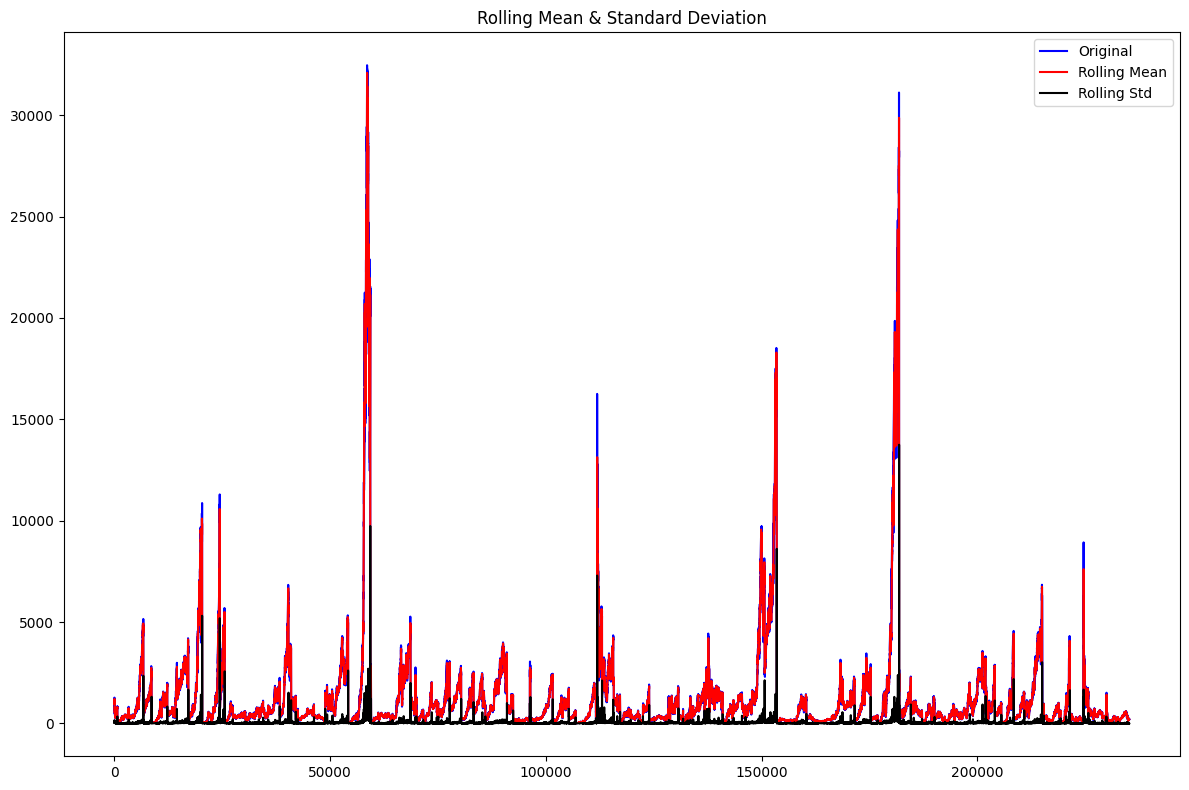

Results of Dickey-Fuller Test for Low:
Test Statistic                -9.069397e+00
p-value                        4.343368e-15
#Lags Used                     8.400000e+01
Number of Observations Used    2.351070e+05
Critical Value (1%)           -3.430378e+00
Critical Value (5%)           -2.861552e+00
Critical Value (10%)          -2.566777e+00
dtype: float64


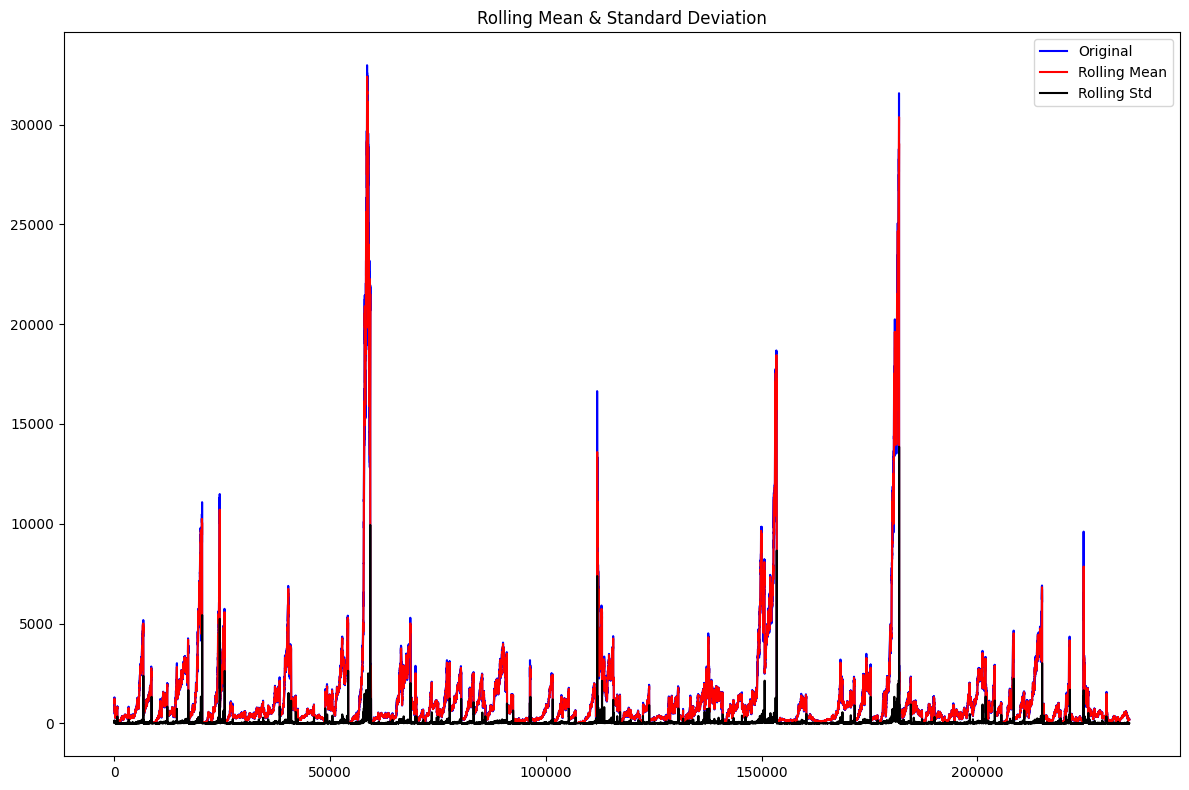

Results of Dickey-Fuller Test for VWAP:
Test Statistic                -9.173349e+00
p-value                        2.355782e-15
#Lags Used                     8.000000e+01
Number of Observations Used    2.351110e+05
Critical Value (1%)           -3.430378e+00
Critical Value (5%)           -2.861552e+00
Critical Value (10%)          -2.566777e+00
dtype: float64


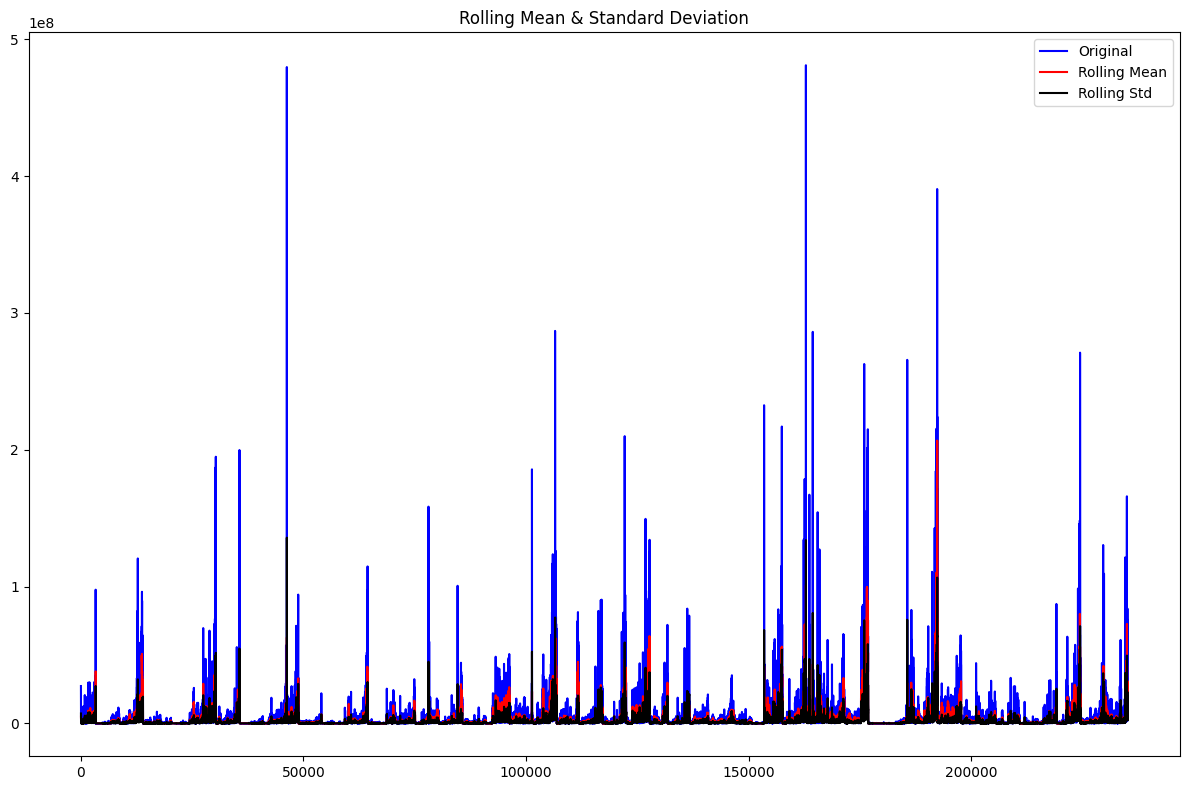

Results of Dickey-Fuller Test for Volume:
Test Statistic                -1.742237e+01
p-value                        4.817813e-30
#Lags Used                     8.400000e+01
Number of Observations Used    2.351070e+05
Critical Value (1%)           -3.430378e+00
Critical Value (5%)           -2.861552e+00
Critical Value (10%)          -2.566777e+00
dtype: float64


In [25]:
# Stationarity test function
def test_stationarity(timeseries, column):
    plt.figure(figsize=(12, 8))
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.tight_layout()
    plt.show()

    print(f'Results of Dickey-Fuller Test for {column}:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

# Apply the stationarity test to key columns
columns_to_test = ['Close', 'Open', 'High', 'Low', 'VWAP', 'Volume']
for column in columns_to_test:
    plt.figure(figsize=(15,8))
    test_stationarity(data[column], column)


Data Scaling:
We scale the data using the MinMaxScaler to normalize the features, ensuring better performance during LSTM training.

In [ ]:
# Data Scaling
scaler = MinMaxScaler()
data_sc = scaler.fit_transform(data[["Close", "Open", "High", "Low", "VWAP", "Volume"]])

In [ ]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  # Assuming 'Close' is the target column
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(data_sc, seq_length)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=1)

In [ ]:
# Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


In [ ]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

In [ ]:
# Hyperparameter Tuning Using RandomSearch
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), return_sequences=False))
    model.add(Dense(1))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error')
    return model

In [ ]:
# RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    directory='random_search',
    project_name='LSTM_tuning'
)

# Run hyperparameter search
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=32)

In [ ]:
# Retrieve the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

In [ ]:
# Evaluate on the test set
test_predictions = best_model.predict(X_test)

# Calculate RMSE and MAE
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)

print(f'Test RMSE: {test_rmse}')
print(f'Test MAE: {test_mae}')

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

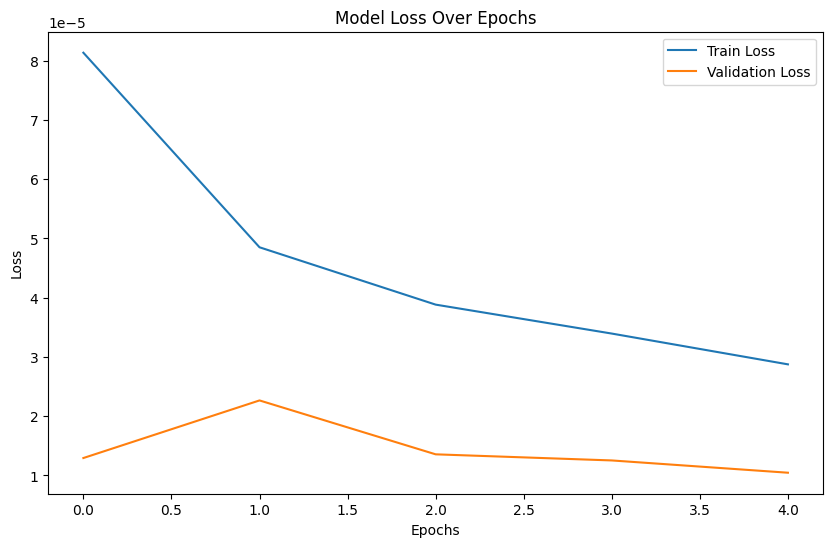

In [68]:
 # Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [107]:
def pred(single_stock_symbol):
    filtered_data = data[data['Symbol'] == single_stock_symbol]
    # Prepare the data
    X = filtered_data[['Open', 'High', 'Low', 'Close', 'VWAP', 'Volume']]
    y = filtered_data['Close']

    # Scale the entire dataset
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Create sequences
    seq_length = 60  # This should match the sequence length used during training
    X_seq, y_seq = [], []
    for i in range(len(X_scaled) - seq_length):
        X_seq.append(X_scaled[i:(i + seq_length)])
        y_seq.append(X_scaled[i + seq_length, 3])  # 3 is the index of 'Close' in X

    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    # Split the data
    split = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    # Forecast future values
    def forecast_future_values(model, last_sequence, scaler, num_steps=60):
        future_predictions = []
        current_sequence = last_sequence.reshape((1, last_sequence.shape[0], last_sequence.shape[1]))

        for _ in range(num_steps):
            # Predict the next step
            next_pred = model.predict(current_sequence)[0]

            # Append the prediction
            future_predictions.append(next_pred)

            # Update the sequence
            current_sequence = np.roll(current_sequence, -1, axis=1)
            current_sequence[0, -1, :] = next_pred

        # Inverse transform
        future_predictions = np.array(future_predictions)
        future_predictions_2d = np.column_stack([future_predictions] * X.shape[1])
        global future_predictions_inv
        future_predictions_inv = scaler.inverse_transform(future_predictions_2d)[:, 3]  # 3 is the index of 'Close'

        return future_predictions_inv

    # Make predictions
    future_predictions = forecast_future_values(best_model, X_test[-1], scaler, num_steps=60)

    # Prepare actual values for plotting
    y_actual = scaler.inverse_transform(X_scaled)[:, 3]  # 3 is the index of 'Close'

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(y_actual)), y_actual, color='blue', label=f'Actual Close Price of {single_stock_symbol}')
    plt.plot(range(len(y_actual), len(y_actual) + 60), future_predictions, color='red', label=f'Forecasted Close Price of {single_stock_symbol}')
    plt.title(f'Actual Close Price and 60-Step Forecast for {single_stock_symbol}')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
    #pd.date_range(start='2020-01-01', periods=60, freq='M')
    return pd.DataFrame( pd.date_range(start='2020-01-01', periods=60, freq='D'),future_predictions_inv) 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

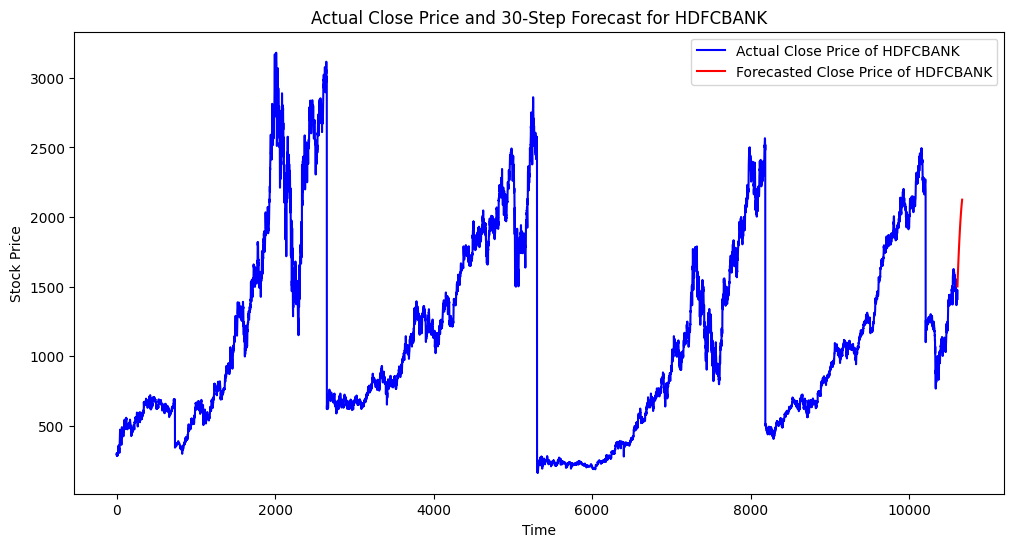

,0
1501.269409,2020-01-01
1514.090454,2020-01-02
1534.709717,2020-01-03
1553.159790,2020-01-04
1569.824097,2020-01-05
1585.333984,2020-01-06
1600.165649,2020-01-07
1614.608154,2020-01-08
1628.802734,2020-01-09
1642.803223,2020-01-10


In [108]:
pred('HDFCBANK')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

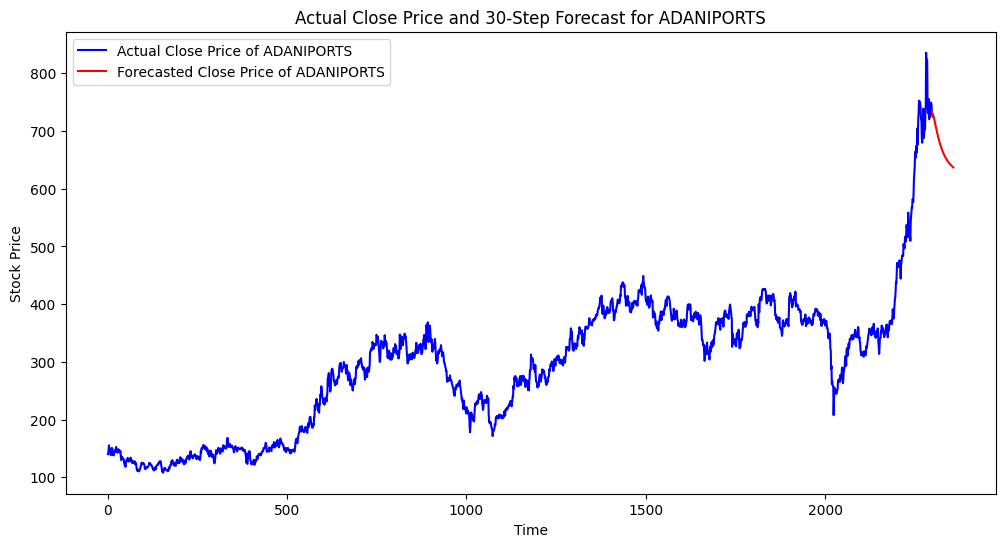

,0
733.277893,2020-01-01
724.467896,2020-01-02
728.170837,2020-01-03
727.243347,2020-01-04
724.685913,2020-01-05
722.050598,2020-01-06
719.242554,2020-01-07
716.316223,2020-01-08
713.360046,2020-01-09
710.409058,2020-01-10


In [109]:
pred('ADANIPORTS')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

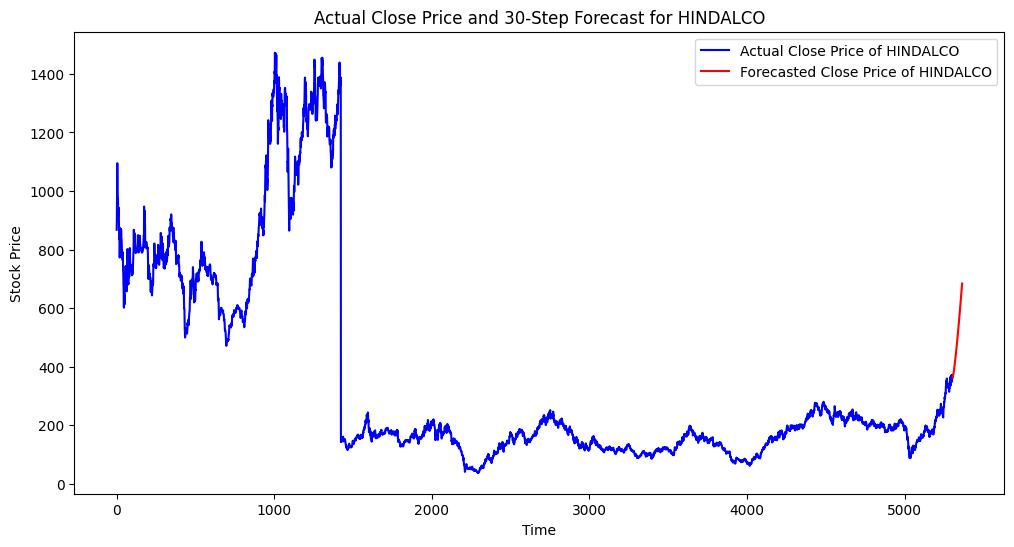

,0
364.130127,2020-01-01
367.656616,2020-01-02
369.666595,2020-01-03
372.206635,2020-01-04
375.310364,2020-01-05
378.878601,2020-01-06
382.765198,2020-01-07
386.845184,2020-01-08
391.038940,2020-01-09
395.307648,2020-01-10


In [111]:
pred('HINDALCO')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

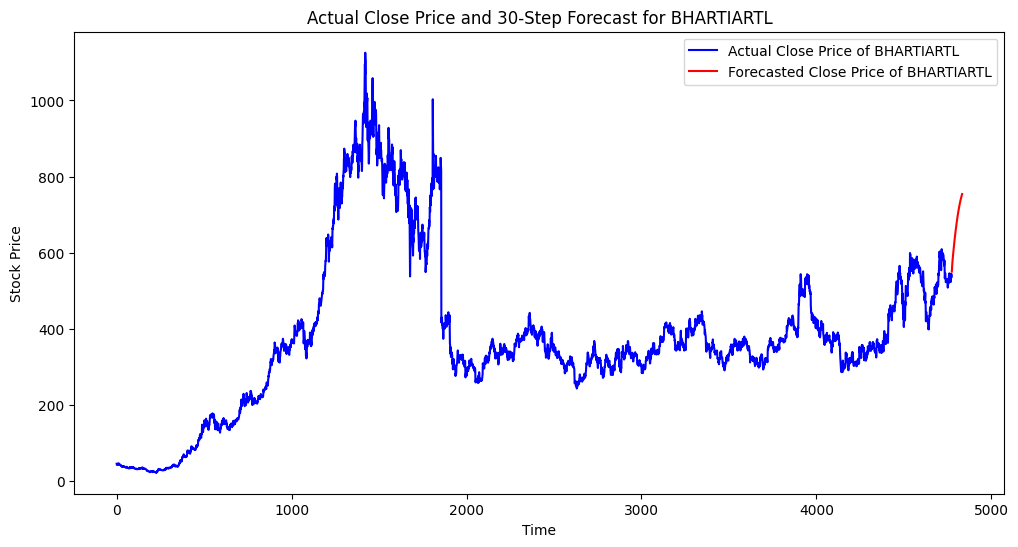

,0
549.889648,2020-01-01
556.133118,2020-01-02
564.760437,2020-01-03
571.679260,2020-01-04
577.547424,2020-01-05
582.863525,2020-01-06
587.911072,2020-01-07
592.827026,2020-01-08
597.661316,2020-01-09
602.424133,2020-01-10


In [110]:
pred('BHARTIARTL')